In [1]:
from itertools import cycle
from pathlib import Path
import math

import matplotlib.pyplot as plt
import numpy as np
import yaml
import torch
from adjustText import adjust_text
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation
from rdkit.Chem import Draw

from rnn_attention import utils, token, augm
from rnn_attention.model import RNNAttention



def GetSimilarityMapFromWeights(
    mol,
    weights,
    colorMap=None,
    scale=-1,
    size=(250, 250),
    sigma=None,
    coordScale=1.5,
    step=0.01,
    colors='k',
    contourLines=10,
    alpha=0.5,
    **kwargs
):
    """
    Generates the similarity map for a molecule given the atomic weights.
    Parameters:
    mol -- the molecule of interest
    colorMap -- the matplotlib color map scheme, default is custom PiWG color map
    scale -- the scaling: scale < 0 -> the absolute maximum weight is used as maximum scale
                          scale = double -> this is the maximum scale
    size -- the size of the figure
    sigma -- the sigma for the Gaussians
    coordScale -- scaling factor for the coordinates
    step -- the step for calcAtomGaussian
    colors -- color of the contour lines
    contourLines -- if integer number N: N contour lines are drawn
                    if list(numbers): contour lines at these numbers are drawn
    alpha -- the alpha blending value for the contour lines
    kwargs -- additional arguments for drawing
    """
    if mol.GetNumAtoms() < 2:
        raise ValueError("too few atoms")
    fig = Draw.MolToMPL(mol, coordScale=coordScale, size=size, **kwargs)
    if sigma is None:
        if mol.GetNumBonds() > 0:
            bond = mol.GetBondWithIdx(0)
            idx1 = bond.GetBeginAtomIdx()
            idx2 = bond.GetEndAtomIdx()
            sigma = 0.3 * math.sqrt(
                    sum([(mol._atomPs[idx1][i] - mol._atomPs[idx2][i])**2 for i in range(2)]))
        else:
            sigma = 0.3 * math.sqrt(sum([(mol._atomPs[0][i] - mol._atomPs[1][i])**2 for i in range(2)]))
        sigma = round(sigma, 2)
    x, y, z = Draw.calcAtomGaussians(mol, sigma, weights=weights, step=step)
    # scaling
    if scale <= 0.0:
        maxScale = max(math.fabs(np.min(z)), math.fabs(np.max(z)))
        minScale = min(math.fabs(np.min(z)), math.fabs(np.max(z)))
    else:
        maxScale = scale

    fig.axes[0].imshow(z, cmap=colorMap, interpolation='bilinear', origin='lower',
                     extent=(0, 1, 0, 1), vmin=minScale, vmax=maxScale)
    # contour lines
    # only draw them when at least one weight is not zero
    if len([w for w in weights if w != 0.0]):
        contourset = fig.axes[0].contour(x, y, z, contourLines, colors=colors, alpha=alpha, **kwargs)
        for j, c in enumerate(contourset.collections):
            if contourset.levels[j] == 0.0:
                c.set_linewidth(0.0)
            elif contourset.levels[j] < 0:
                c.set_dashes([(0, (3.0, 3.0))])
    fig.axes[0].set_axis_off()
    return fig


In [19]:
import math

from rdkit.Chem import Draw

def GetSimilarityMapFromWeights(mol, weights, colorMap=None, scale=-1, size=(250, 250),
                                sigma=None, coordScale=1.5, step=0.01, colors='k', contourLines=10,
                                alpha=0.5, **kwargs):
    """
    Generates the similarity map for a molecule given the atomic weights.
    Parameters:
    mol -- the molecule of interest
    colorMap -- the matplotlib color map scheme, default is custom PiWG color map
    scale -- the scaling: scale < 0 -> the absolute maximum weight is used as maximum scale
                          scale = double -> this is the maximum scale
    size -- the size of the figure
    sigma -- the sigma for the Gaussians
    coordScale -- scaling factor for the coordinates
    step -- the step for calcAtomGaussian
    colors -- color of the contour lines
    contourLines -- if integer number N: N contour lines are drawn
                    if list(numbers): contour lines at these numbers are drawn
    alpha -- the alpha blending value for the contour lines
    kwargs -- additional arguments for drawing
    """
    if mol.GetNumAtoms() < 2:
        raise ValueError("too few atoms")
    fig = Draw.MolToMPL(mol, coordScale=coordScale, size=size, **kwargs)
    if sigma is None:
        if mol.GetNumBonds() > 0:
            bond = mol.GetBondWithIdx(0)
            idx1 = bond.GetBeginAtomIdx()
            idx2 = bond.GetEndAtomIdx()
            sigma = 0.3 * math.sqrt(
                    sum([(mol._atomPs[idx1][i] - mol._atomPs[idx2][i])**2 for i in range(2)]))
        else:
            sigma = 0.3 * math.sqrt(sum([(mol._atomPs[0][i] - mol._atomPs[1][i])**2 for i in range(2)]))
        sigma = round(sigma, 2)
    x, y, z = Draw.calcAtomGaussians(mol, sigma, weights=weights, step=step)
    # scaling
    if scale <= 0.0:
        maxScale = max(math.fabs(np.min(z)), math.fabs(np.max(z)))
        minScale = min(math.fabs(np.min(z)), math.fabs(np.max(z)))
    else:
        maxScale = scale

    fig.axes[0].imshow(z, cmap=colorMap, interpolation='bilinear', origin='lower',
                     extent=(0, 1, 0, 1), vmin=minScale, vmax=maxScale)
    # contour lines
    # only draw them when at least one weight is not zero
    if len([w for w in weights if w != 0.0]):
        contourset = fig.axes[0].contour(x, y, z, contourLines, colors=colors, alpha=alpha, **kwargs)
        for j, c in enumerate(contourset.collections):
            if contourset.levels[j] == 0.0:
                c.set_linewidth(0.0)
            elif contourset.levels[j] < 0:
                c.set_dashes([(0, (3.0, 3.0))])
    fig.axes[0].set_axis_off()
    return fig

['pad', 'unk', '[O-]', '-', '(', '[C@@H]', '[S+2]', '=', '#', '2', 'N', '4', 'F', 'S', '/', '[N+]', 'O', '[C@]', 's', '\\', '3', '1', 'n', '[nH]', '[C@H]', '5', 'Br', ' ', 'I', ')', 'Cl', '[C@@]', 'c', 'C']
34
48
RNNAttention(
  (embedding_layer): Embedding(34, 512)
  (bilstm_layer): LSTM(512, 256, batch_first=True, bidirectional=True)
  (timedistributed_dense_layer): TimeDistributedDense(
    (dense): Linear(in_features=512, out_features=32, bias=True)
  )
  (attention_layer): Attention(
    (inner_dense): Linear(in_features=32, out_features=1, bias=True)
    (tanh): Tanh()
    (softmax): Softmax(dim=1)
  )
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)


/tmp/ipykernel_240013/2902820662.py:2: DeprecationWarning: Please import `shift` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import shift


NameError: name 'tokens_toviz' is not defined

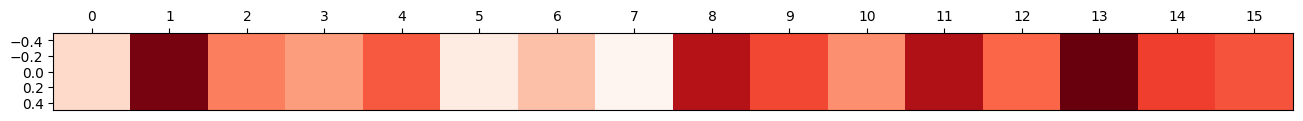

In [13]:
from rdkit import Chem
from scipy.ndimage.interpolation import shift
from sklearn.preprocessing import MinMaxScaler

from rnn_attention import inference


smiles_toviz = "ClC1=C(Cl)[C@]2(Cl)[C@H]3[C@H]4C[C@H]([C@@H]5O[C@@H]54)[C@H]3[C@@]1(Cl)C2(Cl)Cl"
device = "cpu"


mol_toviz = Chem.MolFromSmiles(smiles_toviz)
if mol_toviz != None:
    smiles_toviz_can = Chem.MolToSmiles(mol_toviz)
else:
    print("***Process of visualization automatically aborted!***")
    print("The smiles_toviz is incorrect and cannot be canonicalized by RDKit.")
property_name = "FreeSolv"
model_dir = Path(f"./../models/{property_name}")

smiles_toviz_x = [smiles_toviz_can]
max_length, tokens, model = inference.make_model(model_dir, device)
smiles_tovix = inference.list_to_array(smiles_toviz_x, tokens)
vocab_size = len(tokens)
print(tokens)
print(vocab_size)
print(max_length)
dataset, enum_card = inference.make_dataset(
    smiles_toviz_x, tokens, max_length
)
print(model)
def store_feature(module, input, output):
    global intermediate_output
    intermediate_output = output
model.timedistributed_dense_layer.register_forward_hook(store_feature)

model.eval()
for X, _ in dataset:
    X = X.to(device)
    y_pred = model(X)
#     y_pred = model

# with torch.no_grad():
#     output = model(dataset[0])
intermediate_output_cumsum = np.cumsum(enum_card)
enum_card_toviz_shift = shift(intermediate_output_cumsum, 1, cval=0)
mols_id = 0

ienumcard = enum_card_toviz_shift[mols_id]

smiles_len_tmp = enum_card[0]
# smiles_len_tmp = max_length
intermediate_output_tmp = (
    intermediate_output.detach()
    .numpy()[ienumcard, -smiles_len_tmp + 1 : -1]
    .mean(axis=1)
    .reshape(1, -1)
)
max_intermediate_output_tmp = np.max(intermediate_output_tmp)


plt.matshow(intermediate_output_tmp, cmap="Reds")
plt.tick_params(axis="x", bottom=False)
plt.xticks([ix for ix in range(smiles_len_tmp - 2)])
plt.xticks(
    range(smiles_len_tmp - 2),
    [
        int_to_token[iint].replace("pad", "")
        for iint in tokens_toviz.detach().numpy()[ienumcard, -smiles_len_tmp + 1 : -1]
    ],
    fontsize=12,
    rotation="vertical",
)
plt.yticks([])
plt.show()

tokens_toviz = tokens_toviz.detach().numpy()

smiles_tmp = "".join(enum_smiles_toviz_x[ienumcard])
mol_tmp = Chem.MolFromSmiles(smiles_tmp)
smiles_len_tmp = len(enum_smiles_toviz_x[ienumcard])
mol_df_tmp = pd.DataFrame(
    [
        enum_smiles_toviz_x[ienumcard][1:-1],
        intermediate_output[ienumcard].mean(axis=1).tolist()[-smiles_len_tmp + 1 : -1],
    ]
).transpose()
bond = ["-", "=", "#", "$", "/", "\\", ".", "(", ")"]
mol_df_tmp = mol_df_tmp[~mol_df_tmp.iloc[:, 0].isin(bond)]
mol_df_tmp = mol_df_tmp[
    [not itoken.isdigit() for itoken in mol_df_tmp.iloc[:, 0].values.tolist()]
]

minmaxscaler = MinMaxScaler(feature_range=(0, 1))
norm_weights = (
    minmaxscaler.fit_transform(mol_df_tmp.iloc[:, 1].values.reshape(-1, 1))
    .flatten()
    .tolist()
)
fig = GetSimilarityMapFromWeights(
    mol=mol_tmp,
    size=(250, 250),
    scale=-1,
    sigma=0.05,
    weights=norm_weights,
    colorMap="Reds",
    contourLines=10,
    alpha=0.25,
)
fig.show()

In [7]:
model.timedistributed_dense_layer

AttributeError: 'tuple' object has no attribute 'timedistributed_dense_layer'